In [1]:
from sklearn.naive_bayes import GaussianNB
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import time
from matplotlib import pyplot as plt
import numpy as np
import pickle

In [101]:
df_train = pd.read_csv('train_splitted.csv')
# df_train = pd.read_csv('train.csv')
df_valid = pd.read_csv('valid_splitted.csv')

X_train = df_train.drop(columns=['ID_code', 'target'])
X_valid = df_valid.drop(columns=['ID_code', 'target'])

y_train = df_train['target']
y_valid = df_valid['target']

In [93]:
clf = GaussianNB()
%time clf.fit(X_train.values, y_train.values)

CPU times: user 2.2 s, sys: 278 ms, total: 2.48 s
Wall time: 517 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [94]:
predicted_val = clf.predict_proba(X_valid)
roc_auc_score(y_valid, predicted_val[:,1])

0.8937572270399132

In [5]:
corrs = df_train.corr()
corr_with_target = corrs['target'][1:].values
vars_distribution = np.square(corr_with_target)/np.square(corr_with_target).sum()

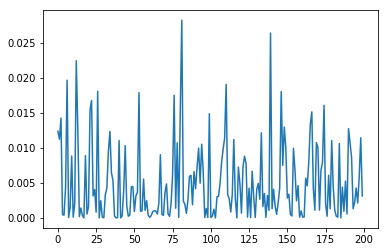

In [6]:
plt.plot(vars_distribution)

In [7]:
np.random.seed(42)

In [8]:
B = 5000

In [9]:
X_train_np = X_train.values
y_train_np = y_train.values
n_max_vars = X_train_np.shape[1]
n_vars = 50
N = len(X_train_np)
models = []
vars_indexes_array = []
for b in range(B):
    print('\r b:', str(b), end='')
    indexes = np.random.randint(N, size=N)
    vars_indexes = np.random.randint(n_max_vars, size=n_vars)
    #vars_indexes = np.random.choice(n_max_vars, n_vars, p=vars_distribution)
    vars_indexes_array.append(vars_indexes)
    clf = GaussianNB()
    #print(X_train_np[indexes][:,vars_indexes].shape)
    clf.fit(X_train_np[indexes][:,vars_indexes], y_train_np[indexes])
    models.append(clf)

 b: 4999

In [10]:
X_valid_np = X_valid.values
predicted_sum = np.zeros(len(y_valid))
for b in range(B):
    predicted_val = models[b].predict_proba(X_valid_np[:,vars_indexes_array[b]])
    predicted_sum = predicted_sum + predicted_val[:,1]
    roc_auc = roc_auc_score(y_valid, predicted_val[:,1])
    print(roc_auc, end=' / ')

0.7150819254004166 / 0.6749174262461595 / 0.7242531331040745 / 0.6944641698093913 / 0.712557191582313 / 0.7304117423203484 / 0.6973357905589417 / 0.7241658896128453 / 0.7301000122915288 / 0.6789477762164082 / 0.718240307294808 / 0.6887742231814277 / 0.6941296471782045 / 0.7062777266515602 / 0.7090425722973109 / 0.740079966060442 / 0.7264552760810257 / 0.7252457852633687 / 0.6788998156380539 / 0.6812912058670685 / 0.7102867737768859 / 0.7289057417146694 / 0.7181952987703748 / 0.7091344498266718 / 0.7089705559121209 / 0.7214006869745275 / 0.7051899359731086 / 0.7020590081801826 / 0.7396185668978258 / 0.7320154215846054 / 0.695505139539607 / 0.7157311507100692 / 0.7060166071843821 / 0.7075132367351723 / 0.7154052370919451 / 0.7072003052890592 / 0.7270860956777427 / 0.676059541582 / 0.7001788244421497 / 0.699189199854435 / 0.7145662976937952 / 0.6908029089621721 / 0.7152613416263989 / 0.7023803083558998 / 0.7136417693276599 / 0.6855763730126362 / 0.7238585533386989 / 0.7496642210295864 / 0

In [12]:
roc_auc_score(y_valid, predicted_sum)

0.8931869588747858

In [11]:
Bootstrap = 0.8931869588747858 # 5000
Bootstrap = 0.8923297991252254 # 500
Bootstrap = 0.8921781184756175 # 100
Original =  0.8921595960535734

# Bagging

Valid_acc no bagging 0.8921595960535734

In [102]:
from sklearn.ensemble import BaggingClassifier

In [103]:
bagg = BaggingClassifier(GaussianNB(), max_samples=1.0, max_features=0.20, n_jobs=10, 
                         n_estimators=5000, bootstrap=True)

In [104]:
%time bagg.fit(X_train, y_train)

CPU times: user 253 ms, sys: 80.5 ms, total: 333 ms
Wall time: 4min 26s


BaggingClassifier(base_estimator=GaussianNB(priors=None, var_smoothing=1e-09),
         bootstrap=True, bootstrap_features=False, max_features=0.2,
         max_samples=1.0, n_estimators=5000, n_jobs=10, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [105]:
roc_auc = roc_auc_score(y_valid, bagg.predict_proba(X_valid)[:, 1]) 
print(roc_auc)

0.8931198785983615


In [99]:
import pickle

In [106]:
pickle.dump(bagg, open('trained_models/GNB_BAGG_0.2_5000_train_only.pk', 'wb'))
# pickle.dump(bagg, open('trained_models/GNB_BAGG_0.2_5000_all_data.pk', 'wb'))

# Boosting

In [37]:
from sklearn.ensemble import AdaBoostClassifier

In [42]:
boost = AdaBoostClassifier(base_estimator=GaussianNB(),
                           n_estimators=1000, 
                           learning_rate=1.0, algorithm='SAMME.R', random_state=42)

In [43]:
boost.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=GaussianNB(priors=None, var_smoothing=1e-09),
          learning_rate=1.0, n_estimators=1000, random_state=42)

In [ ]:
roc_auc = roc_auc_score(y_valid, boost.predict_proba(X_valid)[:, 1]) 
print(roc_auc)

In [49]:
# boost 0.8921595960535734 100

In [53]:
print(roc_auc)

0.8918451130628414
